### Dataset

In [3]:
import pickle
import joblib

In [4]:
import pandas as pd
import numpy as np

In [5]:
izq = pickle.load(open('data/df_clean_izq.pkl','rb'))
izq['bias'] = 'left'
der = pickle.load(open('data/df_clean_der.pkl','rb'))
der['bias'] = 'right'

### Train Test Split

In [6]:
df = izq.loc[:,['body', 'bias']].append(der.loc[:,['body', 'bias']])

In [7]:
X = df.body; y = df.bias

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train,test,y_train,y_test = train_test_split(X, y, train_size=0.75);
train.shape[0] / X.shape[0], test.shape[0] / X.shape[0]

(0.746268656716418, 0.2537313432835821)

### Folds config

In [10]:
from sklearn.model_selection import StratifiedKFold

In [11]:
folds = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)

### Vectorization, Transformation and Training

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import re

In [13]:
stopwords_sp = stopwords.words('spanish') + ['dia', 'fin','dias', 'dos', 'mas','ano', 'año', 'asi','puede', 'mes','incluso']

In [14]:
def removal(text):
    text = re.sub(r'(\d|\$|\%|\+)', '', text.lower())
    return re.sub(r'\d+', '', text)

In [15]:
pipeline = Pipeline([
    ('cv', CountVectorizer(stop_words=stopwords_sp)),
    ('tfidf', TfidfTransformer()),
    ('sgdc', SGDClassifier()),
])

parameters = [
    {
        # vectorizer params
        'cv__max_df': (0.5, 0.75, 1.0),
        'cv__lowercase':  [True],
        'cv__strip_accents':['unicode'], 
        'cv__preprocessor':[removal],
        'cv__ngram_range': [(1,1),(1,2),(2,2)],
        'cv__min_df':[1,2,3],
        # model params
        'sgdc__penalty': ('l2', 'elasticnet', 'l1'),
        'sgdc__max_iter': [50, 80],
        'sgdc__tol': [1e-4],
        #'sgdc__loss': ['hinge', 'log', 'modified_huber'],
        'sgdc__loss': ['log', 'modified_huber'],
    },
]    

In [16]:
grid = GridSearchCV(pipeline, parameters, cv=folds, n_jobs=12, return_train_score=True, verbose=3)
grid.fit(train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:    7.8s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   14.1s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   22.0s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:   45.6s
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 1620 out of 1620 | elapsed:  1.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=19, shuffle=True),
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['de', 'la',
                                                                    'que', 'el',
                                                                    'en', 'y',
                                                                    'a', 'los',
                                                                    'del', 'se',
                                                                    'las',
                                                                    'por', 'un',
                                                                    'para',
                                                                    'con', 'no',
                                                                    'una', 'su',
                                                                    'al', 'lo',
   

In [17]:
display(grid.best_params_, grid.best_score_)

{'cv__lowercase': True,
 'cv__max_df': 1.0,
 'cv__min_df': 3,
 'cv__ngram_range': (1, 1),
 'cv__preprocessor': <function __main__.removal(text)>,
 'cv__strip_accents': 'unicode',
 'sgdc__loss': 'modified_huber',
 'sgdc__max_iter': 50,
 'sgdc__penalty': 'elasticnet',
 'sgdc__tol': 0.0001}

1.0

### Testing and scores

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [19]:
grid.predict(test)

array(['right', 'left', 'left', 'left', 'right', 'left', 'left', 'right',
       'right', 'left', 'right', 'right', 'left', 'left', 'right', 'left',
       'left', 'right', 'right', 'right', 'right', 'left', 'right',
       'left', 'left', 'right', 'right', 'left', 'left', 'left', 'left',
       'left', 'right', 'right'], dtype='<U5')

In [20]:
grid.predict_proba(test)

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.60263949, 0.39736051],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.78801299, 0.21198701],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.

In [21]:
accuracy_score(y_test, grid.predict(test))

1.0

In [22]:
confusion_matrix(y_test, grid.predict(test))

array([[18,  0],
       [ 0, 16]])

In [23]:
classification_report(grid.predict(test), y_test)

'              precision    recall  f1-score   support\n\n        left       1.00      1.00      1.00        18\n       right       1.00      1.00      1.00        16\n\n    accuracy                           1.00        34\n   macro avg       1.00      1.00      1.00        34\nweighted avg       1.00      1.00      1.00        34\n'

### Cloud from Grid
Vectorization with total corpus

In [24]:
cv = grid.best_estimator_['cv'].fit(df.body)

In [25]:
matrix = pd.DataFrame(cv.transform(X).todense(), columns = cv.vocabulary_)

In [26]:
matrix_izq = pd.DataFrame(cv.transform(df[df.bias == 'left'].body).todense(), columns = cv.vocabulary_)
matrix_der = pd.DataFrame(cv.transform(df[df.bias == 'right'].body).todense(), columns = cv.vocabulary_)

In [27]:
matrix_izq.sum().sort_values(ascending=False)[:10]

primarios      149
restricción    104
variaciones     84
conseguir       69
toda            67
reuniones       61
online          58
adultos         58
minoristas      54
afectadas       52
dtype: int64

In [28]:
matrix_der.sum().sort_values(ascending=False)[:10]

variaciones     190
restricción     175
toda            161
primarios       144
rueda           131
próximo         126
fondo           112
razón            99
expectativas     97
retirar          88
dtype: int64

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

(-0.5, 399.5, 199.5, -0.5)

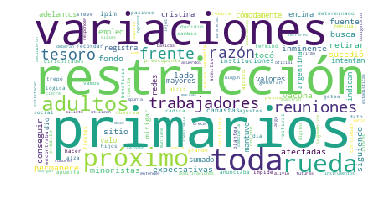

In [30]:
cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(matrix.sum())
plt.imshow(cloud)
plt.axis('off')

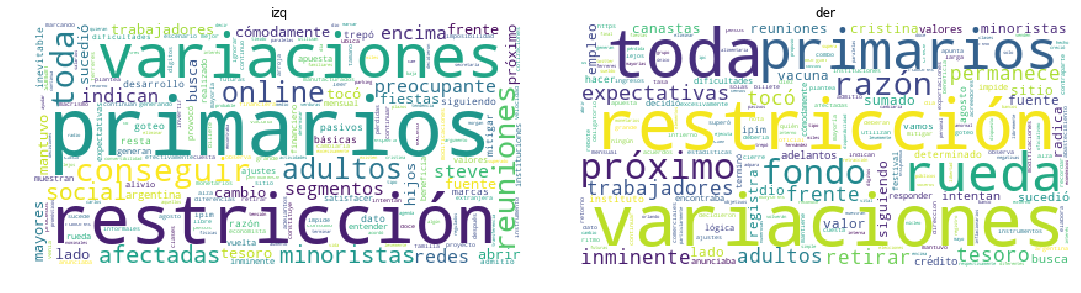

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,30))

cloud = WordCloud(background_color='white')

titles = ['izq', 'der']

for mx, ax, title in zip([matrix_izq, matrix_der], axes.flatten(), titles):
    cloud.generate_from_frequencies(mx.sum())
    ax.imshow(cloud)
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

### Cloud from new Vectorization

In [32]:
vectorizer_preprocessor = CountVectorizer(stop_words = stopwords_sp, lowercase = True, strip_accents='unicode', preprocessor=removal)
vectorizer = CountVectorizer(stop_words = stopwords_sp, lowercase = True, strip_accents='unicode')

In [54]:
vectorizer_preprocessor

CountVectorizer(preprocessor=<function removal at 0x7fd811d119e0>,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')

In [55]:
vectorizer.fit(X)
vectorizer_preprocessor.fit(X)

CountVectorizer(preprocessor=<function removal at 0x7fd811d119e0>,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')

In [72]:
matrix_2_pre = pd.DataFrame(vectorizer_preprocessor.transform(X).todense(), columns = vectorizer_preprocessor.vocabulary_)
matrix_izq_2_pre = pd.DataFrame(vectorizer_preprocessor.transform(df[df.bias == 'left'].body).todense(), columns = vectorizer_preprocessor.vocabulary_)
matrix_der_2_pre = pd.DataFrame(vectorizer_preprocessor.transform(df[df.bias == 'right'].body).todense(), columns = vectorizer_preprocessor.vocabulary_)
print(matrix_2_pre.shape)

(134, 6549)


In [73]:
matrix_2 = pd.DataFrame(vectorizer.transform(X).todense(), columns = vectorizer.vocabulary_)
matrix_izq_2 = pd.DataFrame(vectorizer.transform(df[df.bias == 'left'].body).todense(), columns = vectorizer.vocabulary_)
matrix_der_2 = pd.DataFrame(vectorizer.transform(df[df.bias == 'right'].body).todense(), columns = vectorizer.vocabulary_)
matrix_2.shape

(134, 6828)

In [35]:
matrix_izq_2.sum().sort_values(ascending=False)[:10]

empresariosel    149
arreglar         104
17                89
desfasaje         84
permitian         69
ensanchandose     67
siglos            61
017               58
tensiones         54
llevar            52
dtype: int64

In [36]:
matrix_der_2.sum().sort_values(ascending=False)[:10]

desfasaje        190
arreglar         175
ensanchandose    161
empresariosel    151
elevaria         131
totalizando      126
convergencia     112
excluido          99
17                99
anteriores        97
dtype: int64

(-0.5, 399.5, 199.5, -0.5)

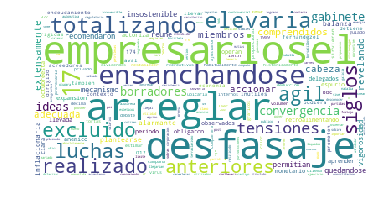

In [37]:
cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(matrix_2.sum())
plt.imshow(cloud)
plt.axis('off')

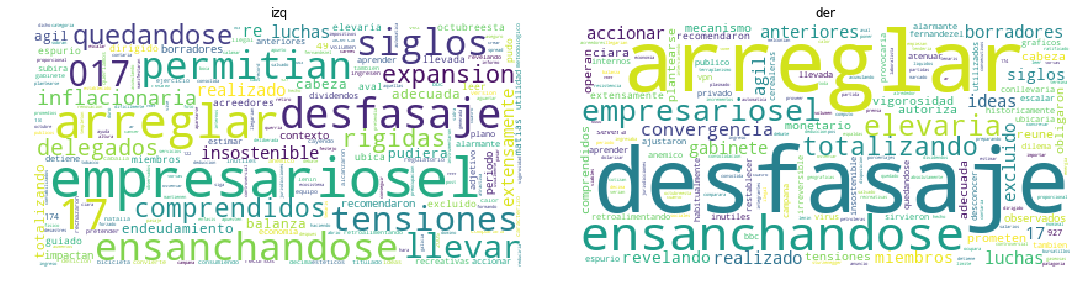

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,30))

cloud = WordCloud(background_color='white')

titles = ['izq', 'der']

for mx, ax, title in zip([matrix_izq_2, matrix_der_2], axes.flatten(), titles):
    cloud.generate_from_frequencies(mx.sum())
    ax.imshow(cloud)
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

#### Cloud with tf-idf

In [39]:
tfidf = TfidfTransformer().fit(matrix_2)

In [40]:
tfidf.transform(matrix_2)

<134x6828 sparse matrix of type '<class 'numpy.float64'>'
	with 25304 stored elements in Compressed Sparse Row format>

In [41]:
matrix_tfidf = pd.DataFrame(tfidf.transform(matrix_2).todense(), columns = vectorizer.vocabulary_)
matrix_izq_tfidf = pd.DataFrame(tfidf.transform(matrix_izq_2).todense(), columns = vectorizer.vocabulary_)
matrix_der_tfidf = pd.DataFrame(tfidf.transform(matrix_der_2).todense(), columns = vectorizer.vocabulary_)

(-0.5, 399.5, 199.5, -0.5)

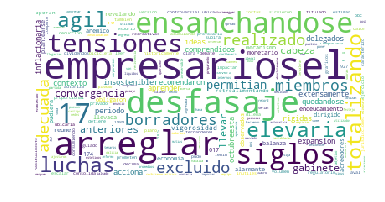

In [42]:
cloud = WordCloud(background_color='white')
cloud.generate_from_frequencies(matrix_tfidf.sum())
plt.imshow(cloud)
plt.axis('off')

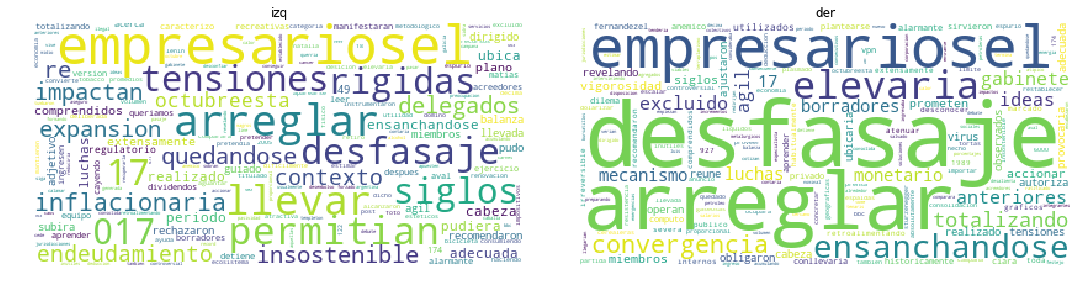

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15,30))

cloud = WordCloud(background_color='white')

titles = ['izq', 'der']

for mx, ax, title in zip([matrix_izq_tfidf, matrix_der_tfidf], axes.flatten(), titles):
    cloud.generate_from_frequencies(mx.sum())
    ax.imshow(cloud)
    ax.set_title(title)
    ax.axis('off')
    
plt.show()

### Pickle

In [44]:
clf = grid.best_estimator_['sgdc']

In [62]:
with open('core/remover.pkl', 'wb') as f:
    print(removal)
    pickle.dump(removal, f)

<function removal at 0x7fd811d119e0>


In [67]:
with open('core/vectorizer.pkl', 'wb') as f:
    f.removal = removal
    vectorizer_preprocessor.fit(X)
    print(vectorizer)
    pickle.dump(vectorizer_preprocessor, f)
    
with open('core/classifier.pkl', 'wb') as f:
    clf.fit(matrix_2, y)
    print(clf)
    pickle.dump(clf, f)

CountVectorizer(stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')
SGDClassifier(loss='modified_huber', max_iter=50, penalty='elasticnet',
              tol=0.0001)


### Joblib

In [47]:
with open('core/vectorizer.joblib', 'wb') as f:
    vectorizer.fit(X)
    joblib.dump(vectorizer, f)
    
with open('core/classifier.joblib', 'wb') as f:
    clf.fit(matrix_2, y)
    joblib.dump(clf, f)

### Dill

In [48]:
import dill

In [60]:
with open('core/remover_dill.pkl', 'wb') as f:
    print(removal)
    pickle.dump(removal, f)

<function removal at 0x7fd811d119e0>


In [75]:
with open('core/vectorizer.dill', 'wb') as f:
    vectorizer_preprocessor.fit(X)
    print(vectorizer_preprocessor)
    dill.dump(vectorizer_preprocessor, f)
    
with open('core/classifier.dill', 'wb') as f:
    clf.fit(matrix_2_pre, y)
    print(clf)
    dill.dump(clf, f)

CountVectorizer(preprocessor=<function removal at 0x7fd811d119e0>,
                stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                            'del', 'se', 'las', 'por', 'un', 'para', 'con',
                            'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                            'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                            'porque', ...],
                strip_accents='unicode')
SGDClassifier(loss='modified_huber', max_iter=50, penalty='elasticnet',
              tol=0.0001)
